# Example: OPO


## Let's try with Marc's waveguide

Author: Luis Ledezma (ledezma@caltech.edu)

## The code

We begin by importing the modules needed, including my own. I also do some formatting. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc
from scipy import signal

#This are my libraries
import nlo 
import pulses
import materials
import waveguides

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [2]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

In [3]:
wl_ff = 2000*nm #Fundamental wavelength
f0_ff = c/wl_ff

#Let's set the bandwdith to LN transparency window or so
f_max = c/(800*nm)
f_min = c/(2.5*um)
BW = f_max - f_min 

#Now we can create the time and frequency arrays
NFFT = 2**10
Tmax = NFFT/BW
dt = 1/BW
t_start = -Tmax/2
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In [4]:
#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f_ref_index = np.abs(f).argmin()

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/um))
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for reference = %i' %(f_ref_index))

Fundamental wavelength = 2000.0 nm
Fundamental frequency = 149.9 THz
Simulation bandwidth = 254.8 THz
Time window size = 4.018 ps
Sampling Rate = 3.924 fs
Frequency Resolution = 248.851 GHz
Reference wavelength = 1212.1 nm
Reference frequency = 247.3 THz
Minimum absolute frequency = 119.9 THz
Maximum absolute frequency = 374.5 THz
Minimum absolute wavelength = 800.5 nm
Maximum absolute wavelength = 2.5 um
Array index for fundamental = 632
Array index for reference = 0


In [5]:
(3*f_max - f_min)/BW

3.938246783088235

## Material properties

I'm going to load the refractive index of lithium tantalate from my personal library named <font color=magenta> materials</font>. In that library I implement mostly Sellmeier's equations obtained from https://refractiveindex.info/ for a few common materials.

In [6]:
width = 1850*nm
hLN = 700*nm
hetch = 340*nm
wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch)
wg.add_narray(wl_abs)

Refractive index at fundamental = 1.874


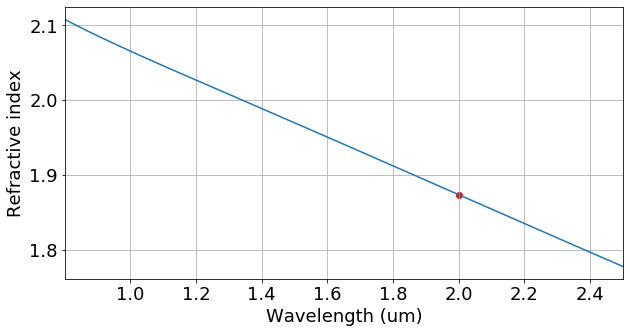

In [7]:
n = wg.neff_array
nw = n[f0_ff_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(n))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

GVM between 2001.6 nm and 999.9 nm = 16.5263 fs/mm
GVD at 2001.6 = -7.3005 fs^2/mm


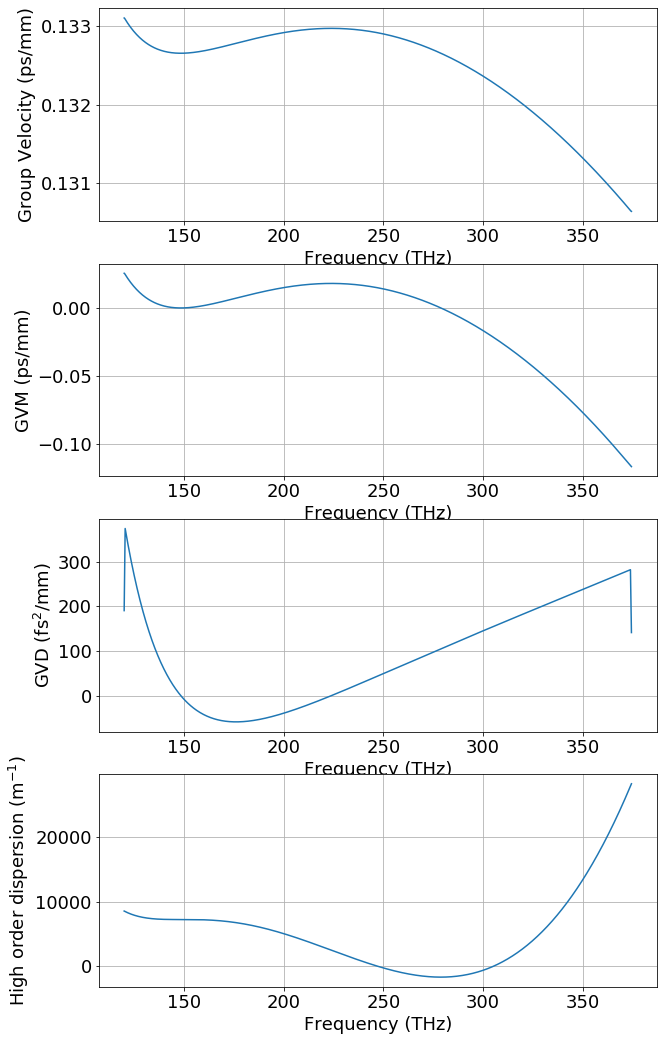

In [8]:
beta = omega_abs*n/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

beta_ref = beta[0]
f_v_ref = f0_ff
f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
v_ref = vg[f_v_ref_index]
D = beta - beta_ref - Omega/v_ref
GVM = 1/v_ref - 1/vg

plt.rcParams['figure.figsize'] = [10, 18]
fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(fftshift(f_abs)/THz, fftshift(vg)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Frequency (THz)');

ax2.plot(fftshift(f_abs)/THz, fftshift(GVM)/(ps/mm));
ax2.set_ylabel('GVM (ps/mm)'); ax2.set_xlabel('Frequency (THz)');

ax3.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax3.set_ylabel('GVD (fs$^2$/mm)'); ax3.set_xlabel('Frequency (THz)');

ax4.plot(fftshift(f_abs)/THz, fftshift(D));
ax4.set_xlabel('Frequency (THz)'); ax4.set_ylabel('High order dispersion (m$^{-1}$)');

ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

f0_sh_index = np.abs(f + f_ref - 2*f0_ff).argmin()
gvm_shg = beta_1[f0_sh_index] - beta_1[f0_ff_index]
print('GVM between %0.1f nm and %0.1f nm = %0.4f fs/mm' %(wl_abs[f0_ff_index]/nm, wl_abs[f0_sh_index]/nm, gvm_shg/(fs/mm)) ) 
print('GVD at %0.1f = %0.4f fs^2/mm' %(wl_abs[f0_ff_index]/nm, beta_2[f0_ff_index]/(fs**2/mm)) )

## Quasi Phase Matching

In [9]:
wl_pp = wl_ff
f1 = c/(wl_pp)
f2 = 2*f1
f1_index = np.abs(f + f_ref - f1).argmin()
f2_index = np.abs(f + f_ref - f2).argmin()

n1 = n[f1_index]
n2 = n[f2_index]

pp = c/f2/(n2-n1)

print("Poling period for second harmonic generation starting at %0.3f um = %0.3f um" %(wl_pp/um, pp/um))

Poling period for second harmonic generation starting at 2.000 um = 5.208 um


In [10]:
# pp = 5.217*um
X0 = 1.1e-12
L = 4*mm
Alpha = 0.1 # attentuation coefficient (dB/cm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

def poling_func(z):
    return np.sign(np.cos(z*2*pi/pp))

wg.add_poling(poling_func)
wg.set_nonlinear_coeffs(N = 1, X0 = X0)
wg.set_length(L)
wg.set_loss(alpha)

## Input pulse creation

We can find the peak value of the pulse from the intensity
$$
E_p = \sqrt{\frac{2 I}{n_\omega c \epsilon_0}}.
$$

The reference frequency $\omega_{ref}$ is mapped to zero in $\Omega$. So, to generate a pulse at frequency $\omega_0$ we need to modulate it:
$$
p(t) e^{j (\omega_0 - \omega_{ref}) t} = p(t) e^{j \Omega_0 t}.
$$

Let's now generate the pulse, add a bit of noise to it, and plot it to verify it is at the right frequency and looks like we expect it to look.

Here I introduce a class named ```pulse```, the goal is to pack everything relevant to the pulse into a single object, just like we did with ```nonlinear_element```. I also have a bunch of convenience methods associated with ```pulse``` for things like plotting, calculating FWHM, energy, etc.

Pulse Energy = 10000.0 fJ
Peak Power = 17599.9 mW


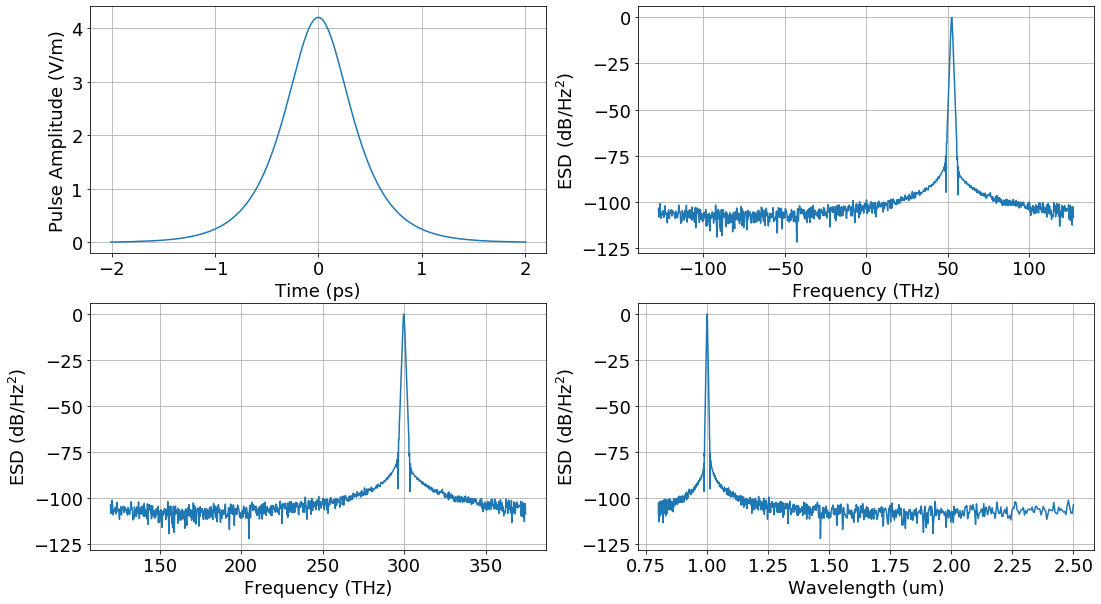

In [11]:
#Frequency offset from reference:
f0_pulse = 2*f0_ff - f_ref

#Pulse width:
tau = 500*fs

#Peak value:
Energy = 10*pJ
Xpeak = np.sqrt((0.94*Energy/tau))

#Noiseless pulse creation
x = pulses.sech(t, Energy, tau, f0_pulse)

#Noise floor
N_dB = 100
Npower = np.amax(np.abs(x))**2 * 10**(-N_dB/10)
noise = pulses.noise(t, Npower)

#Noisy pulse
x = x + noise
pulse = pulses.pulse(t, x, wl_ref)
print('Pulse Energy = %0.1f fJ' %(pulse.energy_td()/fJ))
print('Peak Power = %0.1f mW' %(np.amax( abs(pulse.a)**2 )/mW ))

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = pulse.plot_mag(ax=ax1, t_unit='ps'); ax1.set_ylabel('Pulse Amplitude (V/m)')
ax2 = pulse.plot_ESD_dB(ax=ax2, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax3 = pulse.plot_ESD_dB_absfreq(ax=ax3, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax4 = pulse.plot_ESD_dB_vs_wavelength(ax=ax4, label='ESD (dB/Hz$^2$)', wl_unit='um');

## Single pass

Finally, we can run the simulation. The method ```propagate_NEE``` takes a pulse object, a step size, and a reference velocity for the moving frame and outputs a pulse and it's evolution along the crystal.

In [12]:
h = pp/10 #Step size
[out_pulse, pulse_evol_full] = wg.propagate_NEE(pulse, h, v_ref=v_ref, zcheck_step = 0.5*mm)

Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Completed propagation along 0.50 mm (1.4 s)
Completed propagation along 1.00 mm (1.3 s)
Completed propagation along 1.50 mm (1.3 s)
Completed propagation along 2.00 mm (1.3 s)
Completed propagation along 2.50 mm (1.4 s)
Completed propagation along 3.00 mm (1.3 s)
Completed propagation along 3.50 mm (1.3 s)
Completed propagation along 4.00 mm (1.3 s)
Total time = 11.0 s


In [13]:
print('Input pulse energy = %0.3f fJ' %(pulse.energy_td()/fJ))
print('Output pulse energy = %0.3f fJ' %(pulses.energy_td(t, out_pulse)/fJ))

Input pulse energy = 9999.972 fJ
Output pulse energy = 9908.300 fJ


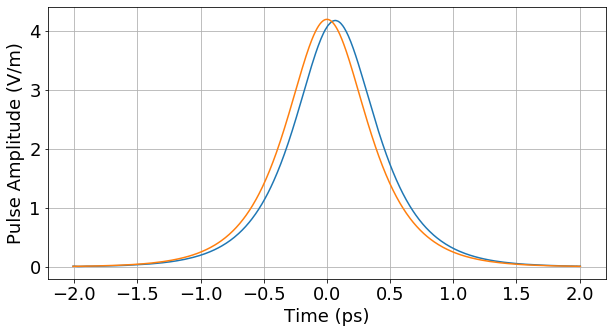

In [14]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulses.plot_mag(t, out_pulse)
ax1 = pulse.plot_mag(ax=ax1)
ax1.set_ylabel('Pulse Amplitude (V/m)')
ax1.set_xlabel('Time (ps)');

Text(0, 0.5, '')

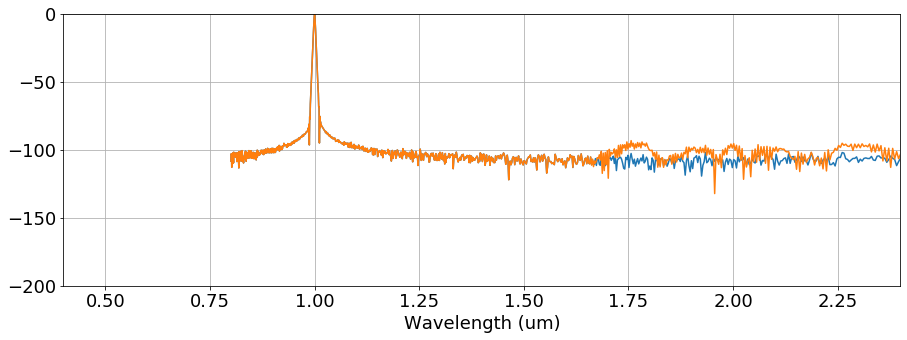

In [15]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
pulse.plot_ESD_dB_vs_wavelength(ax=ax1)
pulses.plot_ESD_dB_vs_wavelength(t, out_pulse, f_ref, ax=ax1)
ax1.set_xlim([0.4, 2.4])
ax1.set_ylim([-80,0])
ax1.set_ylim([-200,0])
ax1.set_ylabel('')

We can also look at the evolution of the pulse along the crystal. Here it also clear that the input pulse travels while it creates a faint second harmonic that is stationary in the simulation frame. 

## Pulse evolution along the crystal

In [16]:
#Downsample evolution for plotting
Ndown = 100
pulse_evol = pulse_evol_full[::,::Ndown]
Nsteps = pulse_evol.shape[1]-1

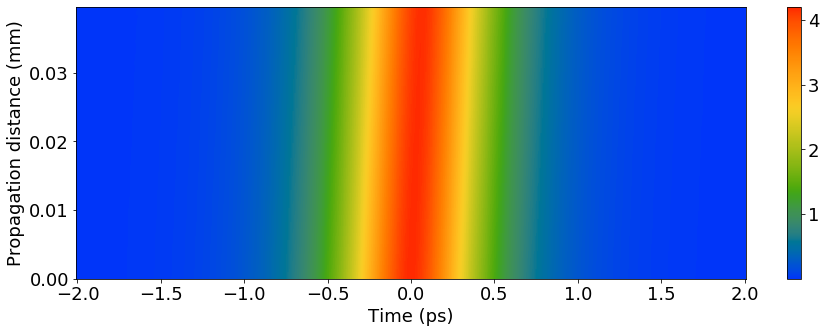

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
Nsteps = pulse_evol.shape[1]-1
X,Y = np.meshgrid(t/ps, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(pulse_evol))), cmap = cc.cm["rainbow"])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
# ax.set_ylim([0,5])
# ax.set_xlim([-2,0.5])
plt.colorbar(im, ax=ax);

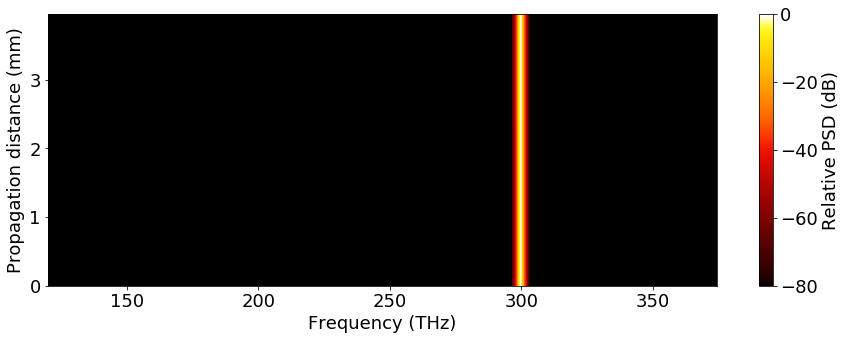

In [18]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = pulse_evol[:,k]
    _ , Aesd = pulses.get_esd(t, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

plt.rcParams['figure.figsize'] = [15, 5]

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*Ndown/mm)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

### Let's check the energy progression along the crystal

Text(0, 0.5, 'Pulse Amplitude (V/m)')

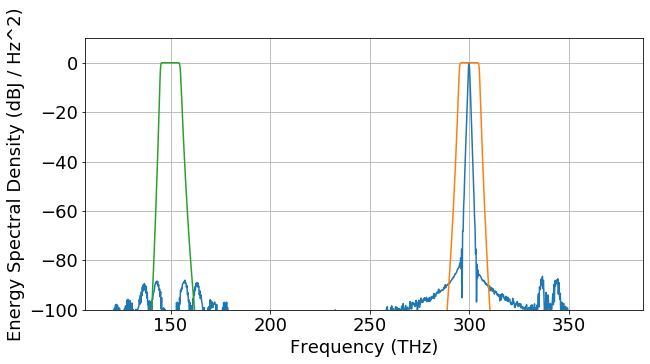

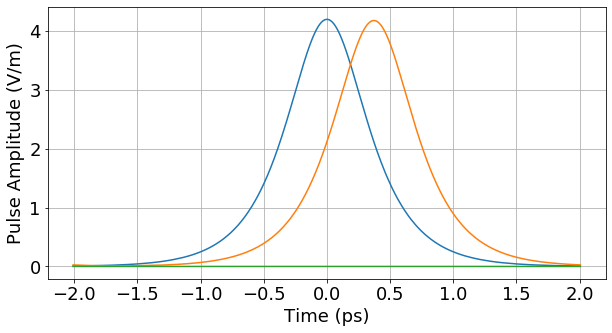

In [32]:
filter_bw = 10*THz

out_ff, h_ff = pulses.filter_signal(f_abs, fft(out_pulse), 1*f0_ff, filter_bw)
out_sh, h_sh = pulses.filter_signal(f_abs, fft(out_pulse), 2*f0_ff, filter_bw)

# out_sh = ifft(fft(out_pulse)*fftshift(h_sh))
# out_ff = ifft(fft(out_pulse)*fftshift(h_ff))

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulses.plot_ESD_dB_absfreq(t, out_pulse, f_ref)
ax1.plot(fftshift(f_abs)*1e-12, 20*np.log10(abs(h_sh + 1e-20)));
ax1.plot(fftshift(f_abs)*1e-12, 20*np.log10(abs(h_ff + 1e-20)))
ax1.set_ylim([-100,10])
# ax1.set_xlim([150, 500])

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulse.plot_mag()
ax1 = pulses.plot_mag(t, out_sh, ax=ax1)
ax1 = pulses.plot_mag(t, out_ff, ax=ax1)
ax1.set_ylabel('Pulse Amplitude (V/m)')
# ax1.set_xlim([-1, 1])

## OPO

In [29]:
feedback_wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch)
feedback_wg.add_narray(wl_abs)
feedback_wg.set_length(6*mm)
feedback_wg.set_loss(alpha)
Output_coupling_loss = 0.99

In [35]:
Nround_trips = 1000
signal = pulses.noise(t, Npower)
                      
for kn in range(Nround_trips):
    print('Roundtrip #%i' %(kn+1) )
    
    ## Generate pump pulse
    pump = pulses.sech(t, Energy, tau, f0_pulse)# + pulses.noise(t, Npower)
    
    ## Add signal
    total = pump + signal
    pulse = pulses.pulse(t, total, wl_ref)
    
    ## Propagate pulse
    [out_pulse, _] = wg.propagate_NEE(pulse, h, v_ref=v_ref, verbose=False)
    
    #Feedback just signal
#     [signal, _] = pulses.filter_signal(f_abs, fft(out_pulse), f0_ff, filter_bw)
    signal = ifft(fft(out_pulse)*fftshift(h_ff))
    signal = pulses.pulse( t, signal, wl_ref )
    signal = feedback_wg.propagate_linear( signal )
    signal = signal.a * Output_coupling_loss
    print()

Roundtrip #1
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 10.3 s

Roundtrip #2
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #3
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #4
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #5
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 10.0 s

Roundtrip #6
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #7
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #8
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #9
Using 4x 

Total time = 9.8 s

Roundtrip #68
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #69
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #70
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #71
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 10.0 s

Roundtrip #72
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #73
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #74
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #75
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.

Total time = 9.9 s

Roundtrip #135
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #136
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #137
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #138
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #139
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #140
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #141
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #142
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.7 s

Roundtrip #202
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #203
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #204
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #205
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #206
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #207
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #208
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #209
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.9 s

Roundtrip #269
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #270
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #271
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #272
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #273
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #274
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #275
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #276
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.9 s

Roundtrip #336
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #337
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #338
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #339
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #340
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #341
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #342
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #343
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.7 s

Roundtrip #403
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #404
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #405
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #406
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #407
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #408
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #409
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #410
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.9 s

Roundtrip #470
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #471
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #472
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #473
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #474
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #475
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #476
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #477
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.7 s

Roundtrip #537
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #538
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #539
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #540
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #541
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #542
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #543
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #544
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.9 s

Roundtrip #604
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #605
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #606
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #607
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #608
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #609
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #610
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #611
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.9 s

Roundtrip #671
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #672
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #673
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #674
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #675
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #676
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #677
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #678
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.7 s

Roundtrip #738
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #739
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 10.0 s

Roundtrip #740
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #741
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #742
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #743
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #744
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #745
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total t

Total time = 9.8 s

Roundtrip #805
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #806
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #807
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #808
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #809
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #810
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #811
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #812
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.8 s

Roundtrip #872
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #873
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #874
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #875
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #876
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #877
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #878
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #879
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

Total time = 9.9 s

Roundtrip #939
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #940
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #941
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #942
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #943
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.9 s

Roundtrip #944
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.7 s

Roundtrip #945
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total time = 9.8 s

Roundtrip #946
Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7680
Total ti

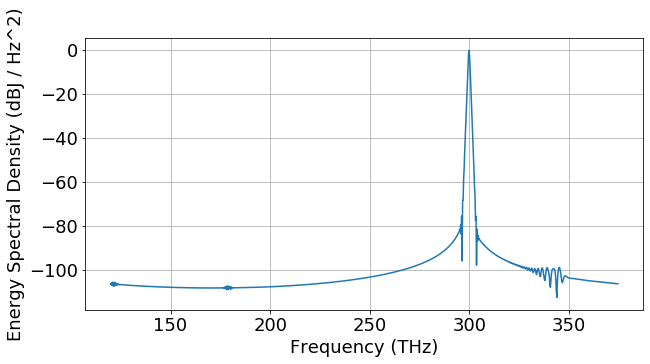

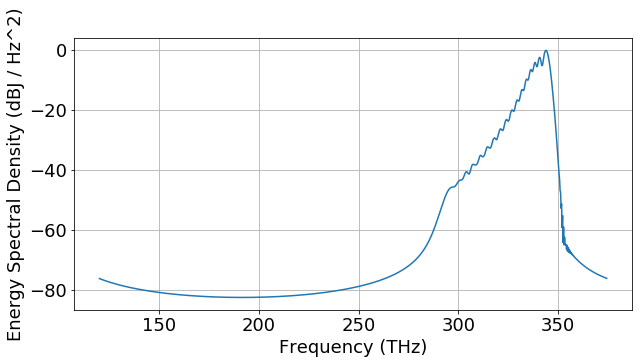

In [36]:
pulses.plot_ESD_dB_absfreq(t, out_pulse, f_ref)
pulses.plot_ESD_dB_absfreq(t, signal, f_ref)

# <center> END OF DOCUMENT </center>

In [23]:
# #Formatting stuff
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("custom.css", "r").read()
#     return HTML(styles)
# css_styling()

### Software Versions

In [24]:
# %load_ext version_information
# %version_information scipy, numpy, matplotlib